In [106]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
torch.set_grad_enabled(False) 
torch.set_printoptions(precision=4,sci_mode=False)

# Config

In [107]:
import torch
from utils import increment_path
from pathlib import Path
import shutil
import os

project = "paper experiment"
name = "SFMCNN"
group = "3/6"
tags = ["SFMCNN", "Rewrite"]
description = "3/6 測試 face 資料集， 15 * 15版本，input size 改為 (60,60)，無overlapping，後面加入(1,2) SFM layer 和一層 (2025,1225,1,1) 的 Conv layer"
device = 'cpu'

lr_scheduler = {
    "name": "ReduceLROnPlateau",
    "args":{
        "patience": 100
    }
}

optimizer = {
    "name":"Adam",
    "args":{

    }
}

arch = {
    "name": 'SFMCNN',
    "args":{
        "in_channels": 1,
        "out_channels": 2,
        "Conv2d_kernel": [(15, 15), (1, 1), (1, 1), (1, 1)],
        "SFM_filters": [(1, 2), (2, 1), (1, 2)],
        "channels": [1, 225, 625, 1225, 2025],
        "strides": [15, 1, 1, 1],
        "paddings": [0, 0, 0, 0],
        "w_arr": [17.45, 17.45, 27.45, 37.45],
        "percent": [0.5, 0.4, 0.3, 0.2],
        "fc_input": 2*1*2025,
        "device": device
    }
}

# arch = {
#     "name": 'SFMCNN_old',
#     "args":{
#         "in_channels": 1,
#         "out_channels": 10,
#     }
# }

# arch = {
#     "name": 'AlexNet',
#     "args":{
#         "num_classes":15
#     }
# }

config = {
    "device": device,
    "root": "os.path.dirname(__file__)",
    "save_dir": './runs/train/exp',
    "model": arch,
    "dataset": 'face_dataset',
    "input_shape": (60, 60),
    "rbf": "triangle",
    "batch_size": 128,
    "epoch" : 20,
    "lr" : 0.001,
    "lr_scheduler": lr_scheduler,
    "optimizer": optimizer,
    "loss_fn": "CrossEntropyLoss",
}

In [108]:
device = 'cpu'
config['device'] = device
arch['device'] = device

# SFMCNN

In [109]:
from torch.nn.modules.utils import _pair
from torch.nn.common_types import _size_2_t
from torch.nn import init
from torch import nn
from torch import Tensor

import torch.nn.functional as F
import torch
import math

class SFMCNN(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 Conv2d_kernel, 
                 channels, 
                 SFM_filters, 
                 strides, 
                 paddings,
                 w_arr,
                 percent,
                 fc_input,
                 device) -> None:
        super().__init__()

        
        # TODO 檢查是否各個block的initial function
        self.convs = nn.Sequential(
                *[self._make_BasicBlock(channels[i], 
                                        channels[i+1], 
                                        Conv2d_kernel[i], 
                                        stride = strides[i],
                                        padding = paddings[i], 
                                        filter = SFM_filters[i], 
                                        percent=percent[i],
                                        w = w_arr[i], 
                                        initial="kaiming",
                                        device = device) for i in range(len(SFM_filters))],
                self._make_ConvBlock(channels[-2], 
                                     channels[-1], 
                                     Conv2d_kernel[-1], 
                                     stride = strides[-1],
                                     padding = paddings[-1], 
                                     percent=percent[-1], 
                                     w=w_arr[-1], 
                                     device = device)
            )


        self.fc1 = nn.Sequential(
            nn.Linear(fc_input, out_channels)
        )

    def forward(self, x):
        output = self.convs(x)
        output = self.fc1(output.reshape(x.shape[0], -1))
        return output

    def _make_BasicBlock(self,
                    in_channels:int, 
                    out_channels:int, 
                    kernel_size:tuple,
                    stride:int = 1,
                    padding:int = 0,
                    filter:tuple = (1,1),
                    w:float = 0.4,
                    percent: float = 0.5,
                    initial: str = "kaiming",
                    device:str = "cuda"):
        return nn.Sequential(
            RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, initial = initial,device = device),
            triangle_cReLU(w=w, percent=percent, requires_grad = True, device=device),
            SFM(filter = filter, device = device)
        )

    def _make_ConvBlock(self,
                    in_channels, 
                    out_channels, 
                    kernel_size,
                    stride:int = 1,
                    padding:int = 0,
                    w = 4.0,
                    percent = 0.4,
                    device:str = "cuda"):
        return nn.Sequential(
            RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, device = device),
            triangle_cReLU(w=w, percent=percent, requires_grad = True, device=device),
        )


'''
    RBF 卷積層
    return output shape = (batches, channels, height, width)
'''
class RBF_Conv2d(nn.Module):
    def __init__(self,
                 in_channels:int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int = 1,
                 padding: int = 0,
                 initial:str = "kaiming",
                 device=None,
                 dtype=None):
        super().__init__()
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = padding
        factory_kwargs = {'device':device, 'dtype':dtype}
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.initial = initial

        self.weight = torch.empty((out_channels, in_channels * self.kernel_size[0] * self.kernel_size[1]), **factory_kwargs)
        self.reset_parameters(initial)
    
    def reset_parameters(self, initial) -> None:
        if initial == "kaiming":
            # kaiming 初始化
            # bound  = sqrt(6/(1 + a^2 * fan))
            # fan = self.weight.size(1) * 1
            init.kaiming_uniform_(self.weight)
        elif initial == "uniform":
            init.uniform_(self.weight)
        else:
            raise "RBF_Conv2d initial error"

        self.weight = nn.Parameter(self.weight)
    
    def forward(self, input: Tensor) -> Tensor:
        # print(f"RBF weights = {self.weight[0]}")
        output_width = math.floor((input.shape[-1] + self.padding * 2 - (self.kernel_size[0] - 1) - 1) / self.stride[0] + 1)
        output_height = math.floor((input.shape[-2] + self.padding * 2 - (self.kernel_size[1] - 1) - 1) / self.stride[1] + 1)
        windows = F.unfold(input, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding).permute(0, 2, 1)

        # TODO weight取平方
        # # 將weight取平方保證其範圍落在 0 ~ 1 之間
        # weights = torch.pow(self.weight, 2)

        #1. 取絕對值距離
        # weight_expand = self.weight.unsqueeze(1).unsqueeze(2)
        # result = (windows - weight_expand).permute(1,0,2,3)
        # result = torch.abs(result).sum(dim=-1)
        
        #2. 取歐基里德距離
        result = torch.cdist(windows, self.weight).permute(0, 2, 1)

        result = result.reshape(result.shape[0], result.shape[1], output_height, output_width)
        return result
    
    def extra_repr(self) -> str:
        return f"initial = {self.initial}, weight shape = {(self.out_channels, self.in_channels, *self.kernel_size)}"

class triangle(nn.Module):
    def __init__(self, 
                 w: float, 
                 requires_grad: bool = False, 
                 device:str = "cuda"):
        super().__init__()
        self.w = torch.Tensor([w]).to(device)
        if requires_grad:
            self.w = nn.Parameter(self.w, requires_grad = True)

    def forward(self, d):
        w_tmp = self.w
        d[d>=w_tmp] = w_tmp
        return torch.ones_like(d) - torch.div(d, w_tmp)
    
    def extra_repr(self) -> str:
        return f"w = {self.w.item()}"

class gauss(nn.Module):
    def __init__(self, std, requires_grad: bool = True, device:str = "cuda"):
        super().__init__()
        self.std = torch.Tensor([std]).to(device)
        if requires_grad:
            self.std = nn.Parameter(self.std)

    def forward(self, d):
        return torch.exp(torch.pow(d, 2) / (-2 * torch.pow(self.std, 2)))
    
    def extra_repr(self) -> str:
        return f"std={self.std.item()}"

class cReLU(nn.Module):
    def __init__(self, 
                 bias: float = 0.7,
                 requires_grad: bool = True,
                 device:str = "cuda") -> None:
        super().__init__()
        self.bias = torch.tensor([bias]).to(device)
        if requires_grad:
            self.bias = nn.Parameter(self.bias, requires_grad = True)
    
    def forward(self, x):
        bias_tmp = self.bias
        result = x * torch.ge(x, bias_tmp.repeat(x.shape[0]).view(-1,1,1,1)).float()
        return result
    
    def extra_repr(self) -> str:
        return f"bias={self.bias.item()}"

class triangle_cReLU(nn.Module):
    def __init__(self, 
                 w: float,
                 percent: float,
                 requires_grad: bool = False, 
                 device:str = "cuda"):
        super().__init__()
        self.w = torch.Tensor([w]).to(device)
        self.percent = torch.tensor([percent]).to(device)
        if requires_grad:
            self.w = nn.Parameter(self.w, requires_grad = True)

    def forward(self, d):
        # input()
        w_tmp = self.w
        # print(f'd = {d[0]}')

        # 1. 取所有數字的對應percent值當作唯一threshold
        tmp = d.reshape(d.shape[0], -1)
        tmp, _ = torch.sort(tmp, dim=-1)
        # 計算在每個 batch 中的索引位置
        index = (self.percent * tmp.shape[1]).long()
        # 通過索引取得百分比元素的值
        threshold = tmp[:, index]
        threshold[threshold>w_tmp] = w_tmp
        threshold = threshold.view(-1,1,1,1)
        # print(f'threshold = {threshold}')

        # #2. 每個channel獨立計算threshold
        # threshold, _ = d.topk(int((1 - self.percent) * d.shape[1]), dim=1)
        # threshold = threshold[:, -1, :, :][:, None, :, :]
        # # 將 threshold 中大於 w 的元素設為 w
        # threshold[threshold > w_tmp] = w_tmp
        # # print(f'threshold = {threshold[0]}')

        # #3. 取beta
        # threshold  = w_tmp * (1 - self.beta)

        d = torch.where(d > threshold, w_tmp, d).view(*d.shape)
        result = (torch.ones_like(d) - torch.div(d, w_tmp))
        # print(f"triangle_cRelu after: {torch.max(result)} ~ {torch.min(result)}")
        # print('-----')
        return result
    
    def extra_repr(self) -> str:
        return f"w = {self.w.item()}, percent={self.percent.item()}"

'''
    時序合併層
    parameters:
        filter: 合併的範圍
'''
class SFM(nn.Module):
    def __init__(self,
                 filter: _size_2_t,
                 alpha_max: float = 0.99,
                 alpha_min: float = 0.9,
                 device: str = "cuda") -> None:
        super(SFM, self).__init__()
        self.filter = filter
        self.alpha = torch.linspace(start=alpha_min, end=alpha_max, steps = math.prod(self.filter), requires_grad=True).reshape(*self.filter)
        self.device = device

    def forward(self, input: Tensor) -> Tensor:
        alpha_pows = self.alpha.repeat(input.shape[1], 1, 1).to(self.device)

        batch_num, channels, height, width = input.shape
        _, filter_h, filter_w = alpha_pows.shape

        # 使用 unfold 將 input 展開成形狀為 (batch_num, channels, (height-filter_h+step)*(width-filter_w+step), filter_h * filter_w) 的二維張量
        unfolded_input = input.unfold(2, filter_h, filter_h).unfold(3, filter_w, filter_w).reshape(batch_num, channels, -1, filter_h * filter_w)

        # 將 filter 擴展成形狀為 (1, channels, 1, filter_h * filter_w)
        expanded_filter = alpha_pows.reshape(channels, 1, -1)
        expanded_filter = expanded_filter.repeat(batch_num, 1, 1, 1)

        # 對應相乘
        result = unfolded_input * expanded_filter

        # 將 dim=-1 的維度相加取 mean
        output = result.mean(dim=-1).reshape(batch_num, channels, math.floor(height/filter_h), math.floor(width/filter_w))
        return output
    
    def extra_repr(self) -> str:
        return f"filter={self.filter}, alpha={self.alpha.detach().numpy()}"

# Load Dataset

In [110]:
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
import numpy as np

images = []
image_paths = []

def custom_sort(filename):
    # 从文件名中提取圈圈顏色和數字部分作为排序依据
    parts = filename.split('_')
    return (parts[0], int(parts[1].split('.')[0]))

image_folder = r'./data/face_dataset/Train'
for root, dirs, files in os.walk(image_folder):
    print(files)
    for i, name in enumerate(sorted(files, key=custom_sort)):
        image = read_image(os.path.join(root, name), ImageReadMode.GRAY)
        image = image / 255
        image = transforms.Resize((60,60))(image)
        images.append(image)

        image_paths.append(os.path.join(root, name))

images = torch.tensor(np.array(images))
print(images.shape)

[]
['face_0.png', 'face_1.png', 'face_10.png', 'face_100.png', 'face_1000.png', 'face_1001.png', 'face_1002.png', 'face_1003.png', 'face_1004.png', 'face_1005.png', 'face_1006.png', 'face_1007.png', 'face_1008.png', 'face_1009.png', 'face_101.png', 'face_1010.png', 'face_1011.png', 'face_1012.png', 'face_1013.png', 'face_1014.png', 'face_1015.png', 'face_1016.png', 'face_1017.png', 'face_1018.png', 'face_1019.png', 'face_102.png', 'face_1020.png', 'face_1021.png', 'face_1022.png', 'face_1023.png', 'face_1024.png', 'face_1025.png', 'face_1026.png', 'face_1027.png', 'face_1028.png', 'face_1029.png', 'face_103.png', 'face_1030.png', 'face_1031.png', 'face_1032.png', 'face_1033.png', 'face_1034.png', 'face_1035.png', 'face_1036.png', 'face_1037.png', 'face_1038.png', 'face_1039.png', 'face_104.png', 'face_1040.png', 'face_1041.png', 'face_1042.png', 'face_1043.png', 'face_1044.png', 'face_1045.png', 'face_1046.png', 'face_1047.png', 'face_1048.png', 'face_1049.png', 'face_105.png', 'face_1

['apple_0.png', 'apple_1.png', 'apple_10.png', 'apple_100.png', 'apple_1000.png', 'apple_1001.png', 'apple_1002.png', 'apple_1003.png', 'apple_1004.png', 'apple_1005.png', 'apple_1006.png', 'apple_1007.png', 'apple_1008.png', 'apple_1009.png', 'apple_101.png', 'apple_1010.png', 'apple_1011.png', 'apple_1012.png', 'apple_1013.png', 'apple_1014.png', 'apple_1015.png', 'apple_1016.png', 'apple_1017.png', 'apple_1018.png', 'apple_1019.png', 'apple_102.png', 'apple_1020.png', 'apple_1021.png', 'apple_1022.png', 'apple_1023.png', 'apple_1024.png', 'apple_1025.png', 'apple_1026.png', 'apple_1027.png', 'apple_1028.png', 'apple_1029.png', 'apple_103.png', 'apple_1030.png', 'apple_1031.png', 'apple_1032.png', 'apple_1033.png', 'apple_1034.png', 'apple_1035.png', 'apple_1036.png', 'apple_1037.png', 'apple_1038.png', 'apple_1039.png', 'apple_104.png', 'apple_1040.png', 'apple_1041.png', 'apple_1042.png', 'apple_1043.png', 'apple_1044.png', 'apple_1045.png', 'apple_1046.png', 'apple_1047.png', 'app

# Load Model

In [111]:
checkpoint = torch.load('face_model_pth/0304_SFMCNN_best_p8jf42wl.pth')

model = SFMCNN(**dict(config['model']['args']))
model.load_state_dict(checkpoint['model_weights'])
model = model.cpu()

kaiming initial fan: 225
kaiming initial bound: 0.16329931618554522
kaiming initial fan: 225
kaiming initial bound: 0.16329931618554522
kaiming initial fan: 625
kaiming initial bound: 0.09797958971132711
kaiming initial fan: 1225
kaiming initial bound: 0.06998542122237653
kaiming initial fan: 4050
kaiming initial bound: 0.01571348402636772


In [112]:
from collections import Counter
input = torch.Tensor(images).float()
outputs = []
with torch.no_grad():
    for i in range(input.shape[0] // 1000):
        pred = model(input[(0 + i * 1000):(1000 + i*1000), :, :, :])
        outputs.append(pred)
outputs = np.array(outputs)
outputs = outputs.reshape(-1, 2)
pred = outputs.argmax(1).tolist()
print(Counter(pred))

Counter({0: 6211, 1: 5789})


# Define function

In [113]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
def plot_map(rm, grid_size=None, rowspan=None, colspan = None, path=None, **kwargs):
    rows, cols, e_h, e_w, _ = rm.shape
    if rowspan is None:
        rowspan = int(e_h / min(e_h, e_w))
    if colspan is None:
        colspan = int(e_w / min(e_h, e_w))
    if grid_size is None:
        grid_size = (rows*rowspan, cols*colspan)
    fig = plt.figure(figsize=(grid_size[1], grid_size[0]), facecolor="green")
    for row in range(rows):
        for col in range(cols):
            ax = plt.subplot2grid(grid_size, (row*rowspan, col*colspan), rowspan=rowspan, colspan=colspan)
            im = ax.imshow(rm[row][col], **kwargs)
            ax.axis('off')
    
    if path:
        plt.savefig(path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

In [114]:
def split(input, kernel_size = (5, 5), stride = (5,5)):
    batch, channel, h, w = input.shape
    output_height = math.floor((h  - (kernel_size[0] - 1) - 1) / stride[0] + 1)
    output_width = math.floor((w  - (kernel_size[1] - 1) - 1) / stride[1] + 1)
    input = torch.tensor(input)
    segments = F.unfold(input, kernel_size=kernel_size, stride=stride).reshape(batch, channel, *kernel_size, -1).permute(0,1,4,2,3)
    segments = segments.reshape(batch, channel, output_height, output_width, *kernel_size) 
    return segments

In [115]:
def get_ci(input, layer, kernel_size = (5,5), stride= (5,5), sfm_filter = (1,1)):
    segments = split(input, kernel_size, stride)
    combine_h, combine_w, ci_h, ci_w = (int(segments.shape[2]/sfm_filter[0]), int(segments.shape[3]/sfm_filter[1]), int(segments.shape[4]*sfm_filter[0]), int(segments.shape[5]*sfm_filter[1]))
    segments = segments.reshape(-1, input.shape[1], combine_h, sfm_filter[0], combine_w, sfm_filter[1], segments.shape[4], segments.shape[5])
    segments = segments.permute(0, 2, 4, 3, 6, 5, 7, 1)
    segments = segments.reshape(-1, ci_h, ci_w, input.shape[1])
    print(f"segments shape: {segments.shape}")
    
    with torch.no_grad():
        outputs = layer(input)
        n_filters = outputs.shape[1]
        outputs = outputs.permute(0,2,3,1).reshape(-1, n_filters)
        print(f"output shape: {outputs.shape}")

    k = 1
    CI = torch.empty(n_filters, k, ci_h, ci_w, input.shape[1])
    CI_values = torch.empty(n_filters, k) 
    CI_idx = torch.empty(n_filters, k)    
    for i in range(n_filters):
        values, indices = torch.topk(outputs[:, i], k=k, largest=False)
        CI_idx[i] = indices
        CI_values[i] = values
        CI[i] = segments[indices.tolist()]
    print(f"CI shape: {CI.shape}")
    return CI, CI_idx, CI_values

# get_ci

# Layer 0

## FM_0

In [116]:
FMs = {}
FMs[0] = model.convs[0][0].weight.reshape(-1, *arch['args']['Conv2d_kernel'][0], 1)
print(f"FMs[0] = {FMs[0].shape}")

FMs[0] = torch.Size([225, 15, 15, 1])


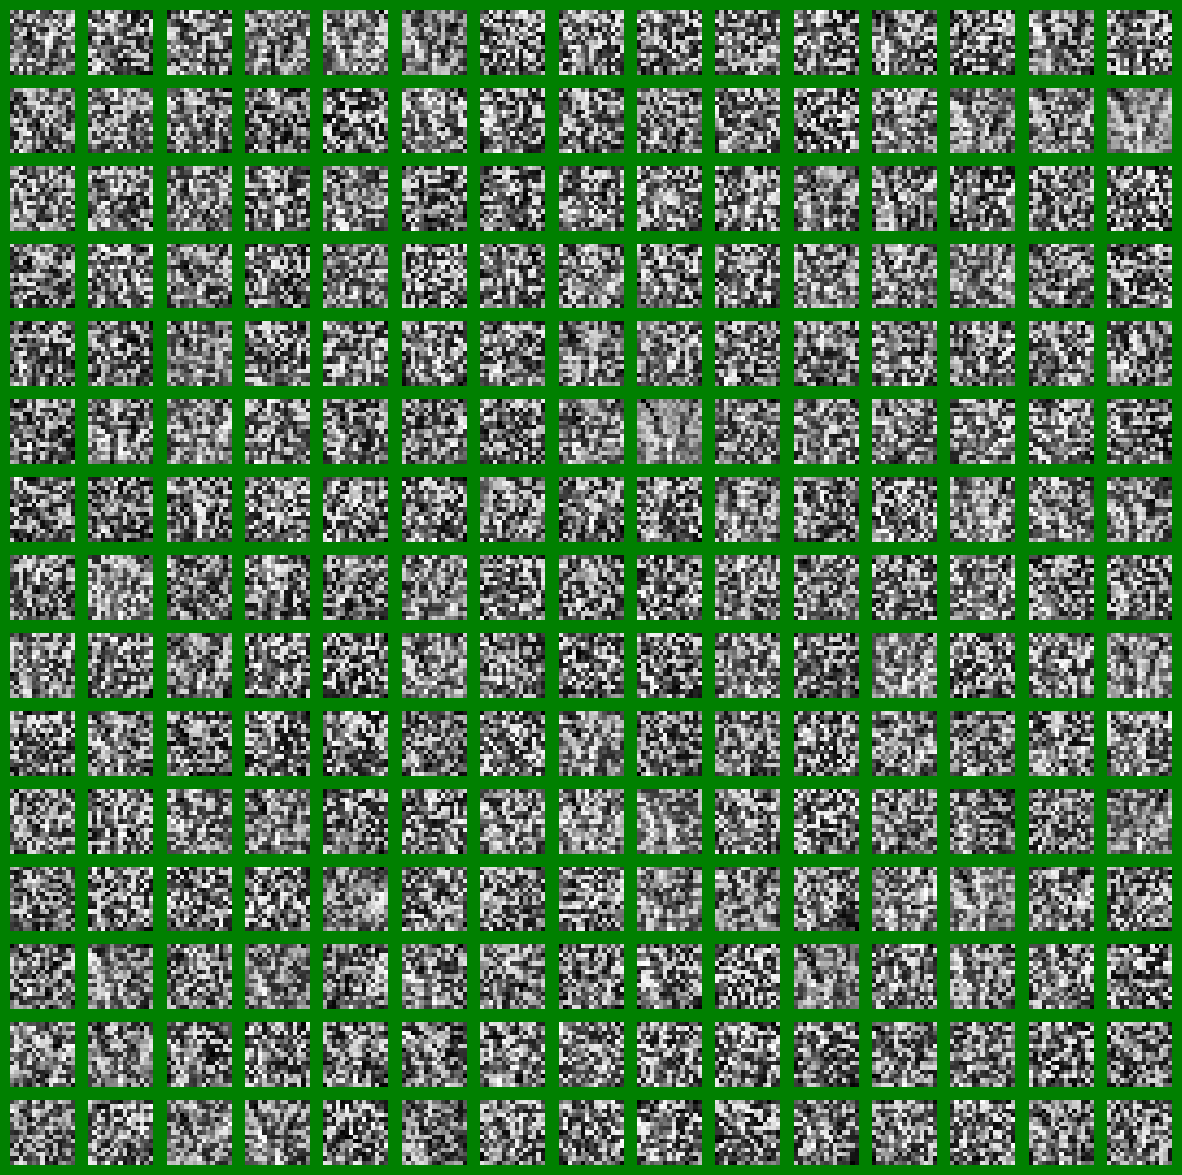

In [117]:
plot_map(FMs[0].reshape(int(FMs[0].shape[0]**0.5), int(FMs[0].shape[0]**0.5), *FMs[0].shape[1:]).detach().numpy(), cmap='gray')

## CI_0

In [118]:
CIs = {}
layer = nn.Sequential(model.convs[0][:1])

kernel_size = arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0]) 

output = layer(images[0].unsqueeze(0))
output_shape = output.shape[1:]

CI, CI_idx, CI_values = get_ci(images, layer, kernel_size=kernel_size, stride=stride)
CIs[0] = CI
print(f"CIs[0] = {CIs[0].shape}")

C:\Users\user\AppData\Local\Temp\ipykernel_32132\909383208.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


segments shape: torch.Size([192000, 15, 15, 1])
output shape: torch.Size([192000, 225])
CI shape: torch.Size([225, 1, 15, 15, 1])
CIs[0] = torch.Size([225, 1, 15, 15, 1])


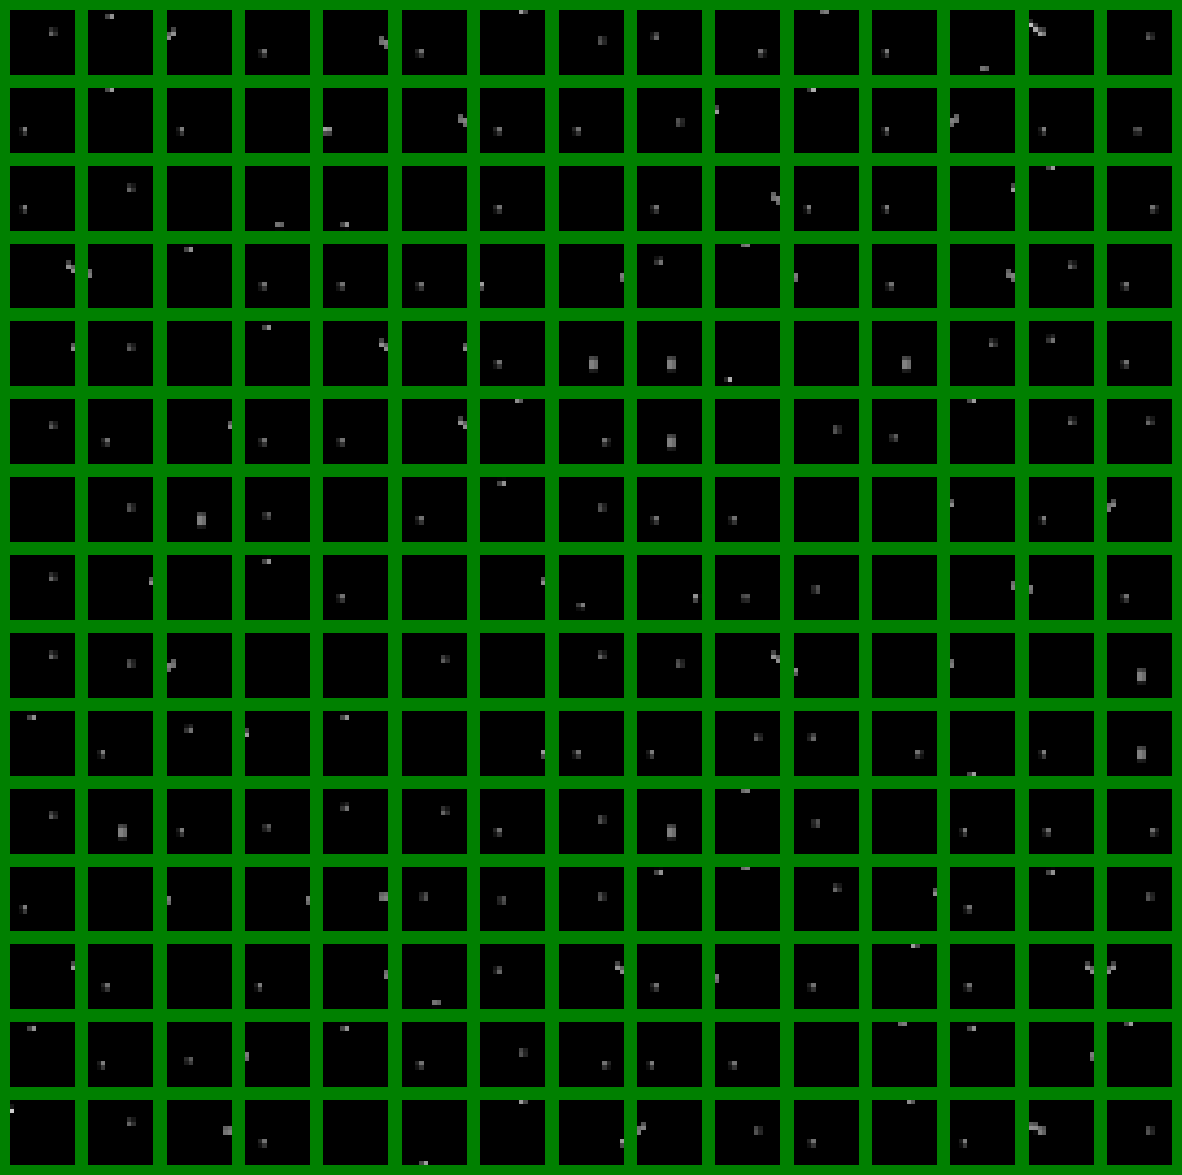

In [119]:
plot_map(CIs[0].reshape(int(CIs[0].shape[0]**0.5), int(CIs[0].shape[0]**0.5),*CIs[0].shape[2:]), cmap='gray', vmax=1, vmin=0)

### Lab


tensor([    -0.2469,      0.0891,      0.2027,     -0.2639,      0.1527,
            -0.0165,      0.1833,      0.1412,     -0.2500,     -0.1499,
            -0.2464,     -0.2912,     -0.1225,     -0.2434,     -0.2322,
            -0.1840,     -0.1086,     -0.0022,     -0.2300,      0.2695,
             0.3236,      0.1523,     -0.1862,     -0.1789,      0.2934,
            -0.2965,     -0.2602,     -0.1344,      0.1609,     -0.2493,
             0.2798,     -0.2394,     -0.1258,     -0.0015,     -0.2261,
             0.2531,      0.2399,     -0.1004,     -0.0497,      0.2481,
            -0.2607,     -0.2096,      0.1118,     -0.2734,      0.2845,
             0.0598,      0.3027,      0.1632,     -0.0616,      0.2287,
             0.2007,     -0.0385,      0.1936,      0.0165,     -0.1573,
            -0.2174,      0.1883,     -0.2964,     -0.2320,      0.2984,
            -0.0647,     -0.1054,      0.2825,      0.2113,      0.0746,
             0.1992,      0.0495,     -0.1337,     

(array([38., 36., 30., 19., 17., 16., 18., 29., 22.]),
 array([-0.3142027 , -0.2433313 , -0.1724599 , -0.10158851, -0.03071711,
         0.04015429,  0.11102568,  0.18189707,  0.25276849,  0.32363987]),
 <BarContainer object of 9 artists>)

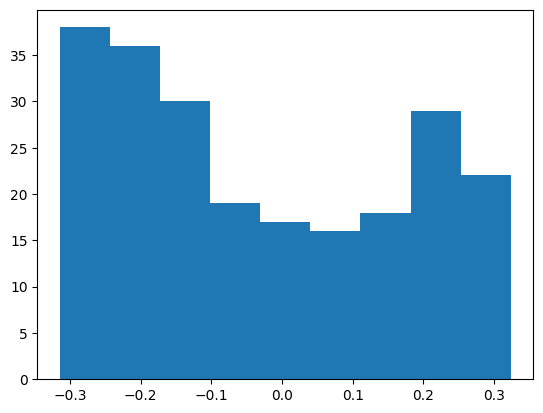

In [120]:
print(FMs[0][1].squeeze(-1).flatten())
plt.hist(FMs[0][1].squeeze(-1).flatten(), bins='auto')

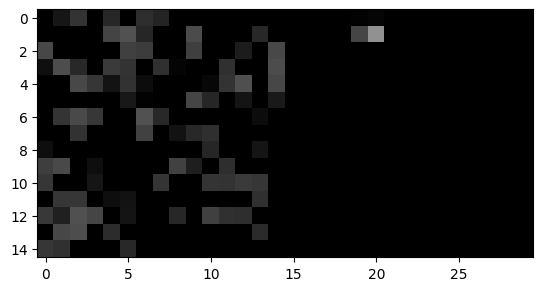

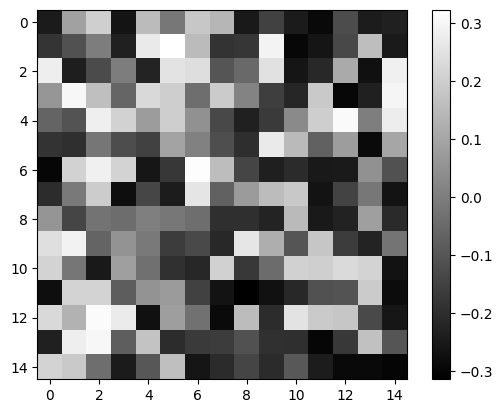

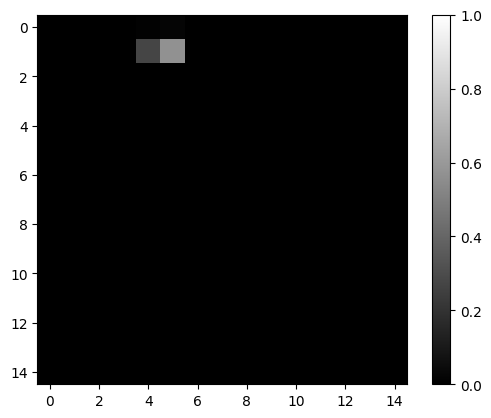

images_idx = 6151, segment_idx = 9

segments.shape = torch.Size([1, 1, 4, 4, 15, 15])


C:\Users\user\AppData\Local\Temp\ipykernel_32132\664969024.py:19: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  images_idx = int(CI_idx[i][0] // 16)
C:\Users\user\AppData\Local\Temp\ipykernel_32132\909383208.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


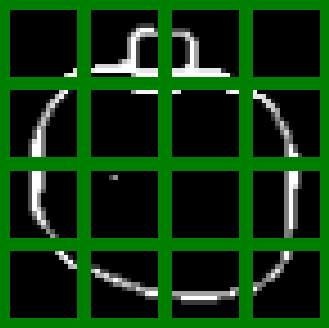

In [121]:
i = 1

plot = torch.empty(15, 15*2, 1)
plot[:, :15] = FMs[0][i]
plot[:, 15:] = CIs[0][i][0]
plt.imshow(plot, cmap='gray',vmax=1 ,vmin=0)
plt.show()

# FM
plt.imshow(FMs[0][i], cmap='gray')
plt.colorbar()
plt.show()
# CI, CI_idx, CI_values
plt.imshow(CIs[0][i][0], cmap='gray',vmax=1 ,vmin=0)
plt.colorbar()
plt.show()


images_idx = int(CI_idx[i][0] // 16)
segment_idx = int(CI_idx[i][0] % 16)
print(f"images_idx = {images_idx}, segment_idx = {segment_idx}")
print(f"")

kernel_size = arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0])

segments = split(images[images_idx].unsqueeze(0), kernel_size=kernel_size, stride=stride)
print(f"segments.shape = {segments.shape}")
plot_map(segments[0].permute(1,2,3,4,0), cmap='gray', vmax=1, vmin=0)


In [122]:
print(CI_values[i])
print(FMs[0][i].shape)

tensor([2.9230])
torch.Size([15, 15, 1])


In [123]:
print(segments.shape)

for idx_i in range(4):
    for idx_j in range(4):
        pow_sum = 0
        for i in range(15):
            for j in range(15):
                pow_sum += (segments[0][0][idx_i][idx_j][i][j] - FMs[0][1][i][j][0])**2
        print(pow_sum ** 0.5)
    print()

torch.Size([1, 1, 4, 4, 15, 15])
tensor(3.7151)
tensor(7.6240)
tensor(7.0404)
tensor(2.9432)

tensor(5.9760)
tensor(4.0111)
tensor(3.7829)
tensor(5.2963)

tensor(5.6161)
tensor(2.9230)
tensor(2.9432)
tensor(5.9620)

tensor(3.9789)
tensor(4.9222)
tensor(5.0825)
tensor(4.0547)



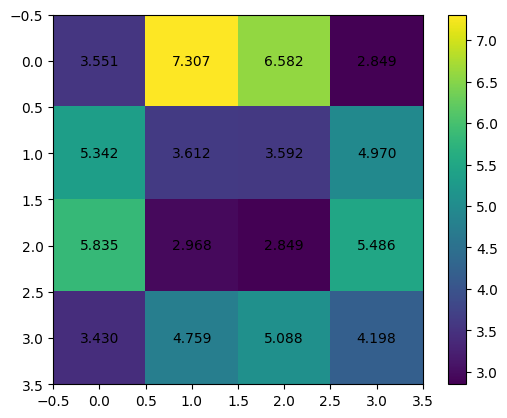

In [124]:
segments_flatten = segments.reshape(16,-1)

dist_arr = torch.cdist(FMs[0][i].reshape(1,-1),segments_flatten)
# dist_arr = 1 - dist_arr / arch['args']['w_arr'][0]
dist_arr = dist_arr.reshape(4,4)

plt.imshow(dist_arr)
plt.colorbar()
for i in range(dist_arr.shape[0]):
    for j in range(dist_arr.shape[1]):
        text = plt.text(j, i, '{:.3f}'.format(dist_arr[i, j]), ha="center", va="center")
plt.show()

# Layer 1

## FM 1

In [123]:
FMs[1] = model.convs[1][0].weight.reshape(-1, int(model.convs[1][0].weight.shape[1]**0.5), int(model.convs[1][0].weight.shape[1]**0.5), 1)
print(f"FMs[1] = {FMs[1].shape}")

FMs[1] = torch.Size([625, 15, 15, 1])


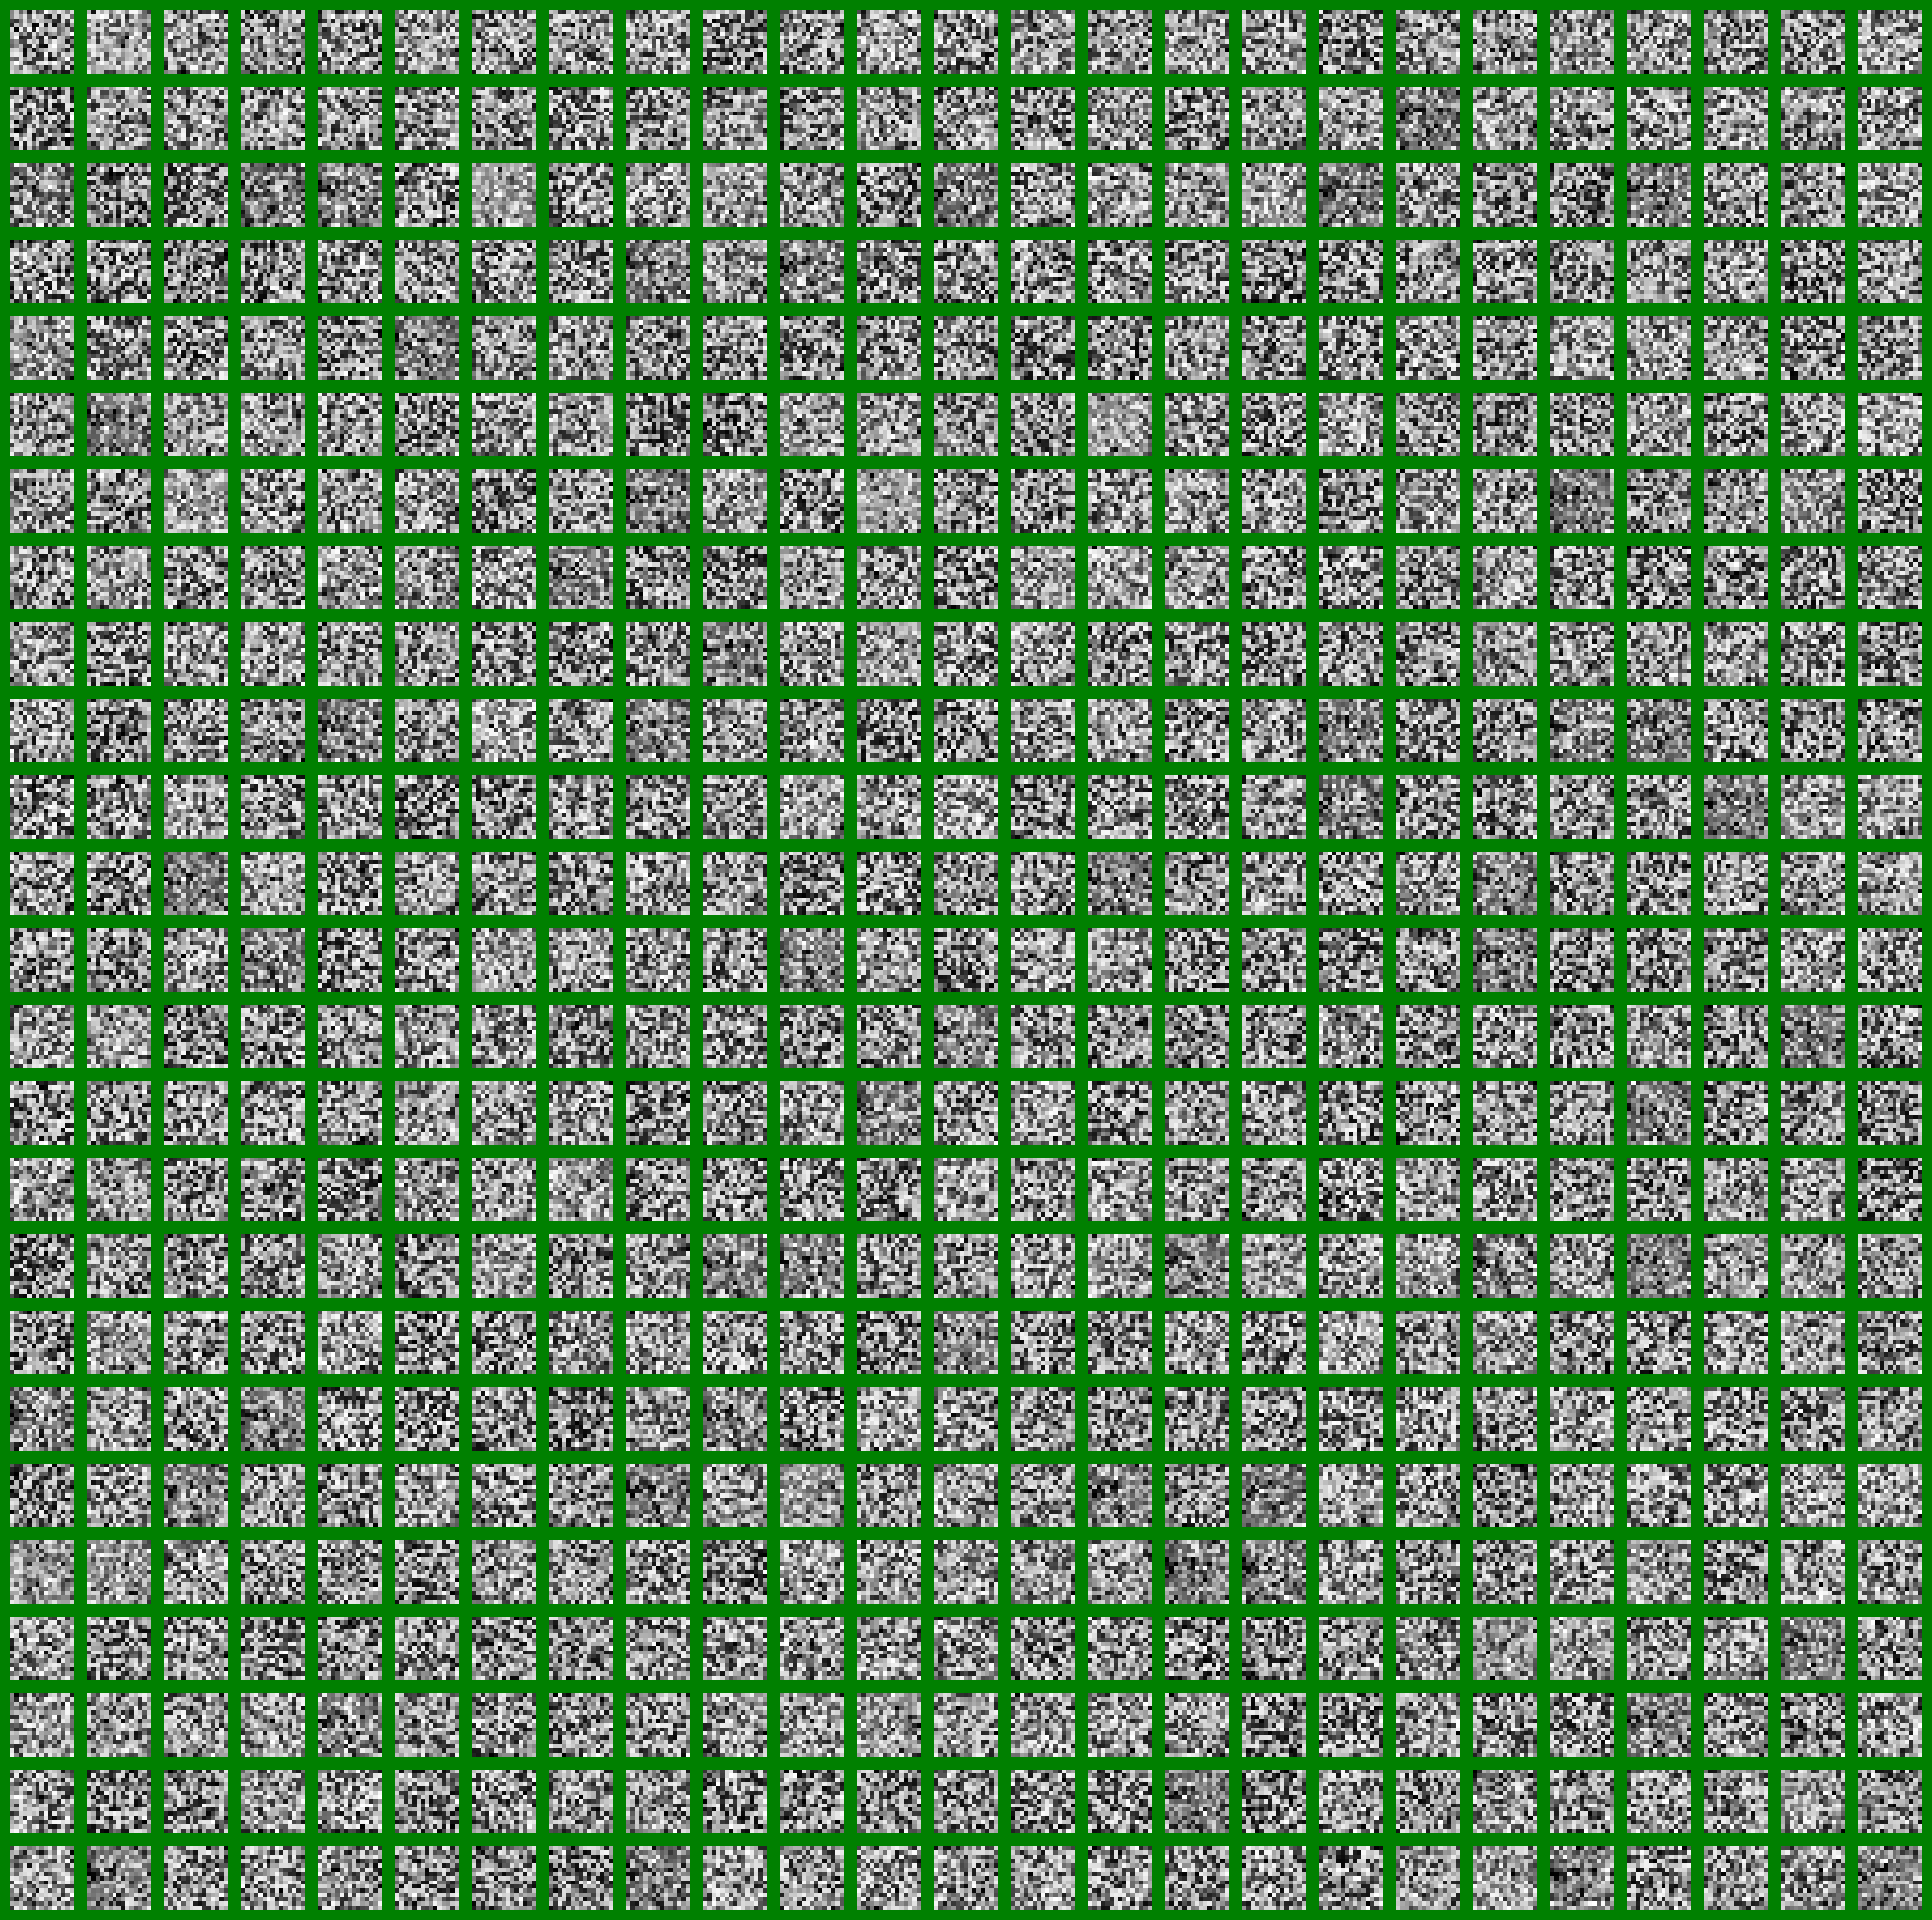

In [125]:
plot_map(FMs[1].reshape(int(FMs[1].shape[0]**0.5), int(FMs[1].shape[0]**0.5), *FMs[1].shape[1:]).detach().numpy(), cmap='gray')

## CI 1

Sequential(
  (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 1, 15, 15))
  (1): triangle_cReLU(w = 17.39649200439453, percent=0.5)
  (2): SFM(filter=(1, 2), alpha=[[0.9  0.99]])
  (3): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
    (1): triangle_cReLU(w = 17.253515243530273, percent=0.4000000059604645)
  )
)
(15, 15) (15, 15) tensor([1, 2])


C:\Users\user\AppData\Local\Temp\ipykernel_32776\909383208.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


segments shape: torch.Size([96000, 15, 30, 1])
output shape: torch.Size([96000, 625])
CI shape: torch.Size([625, 1, 15, 30, 1])


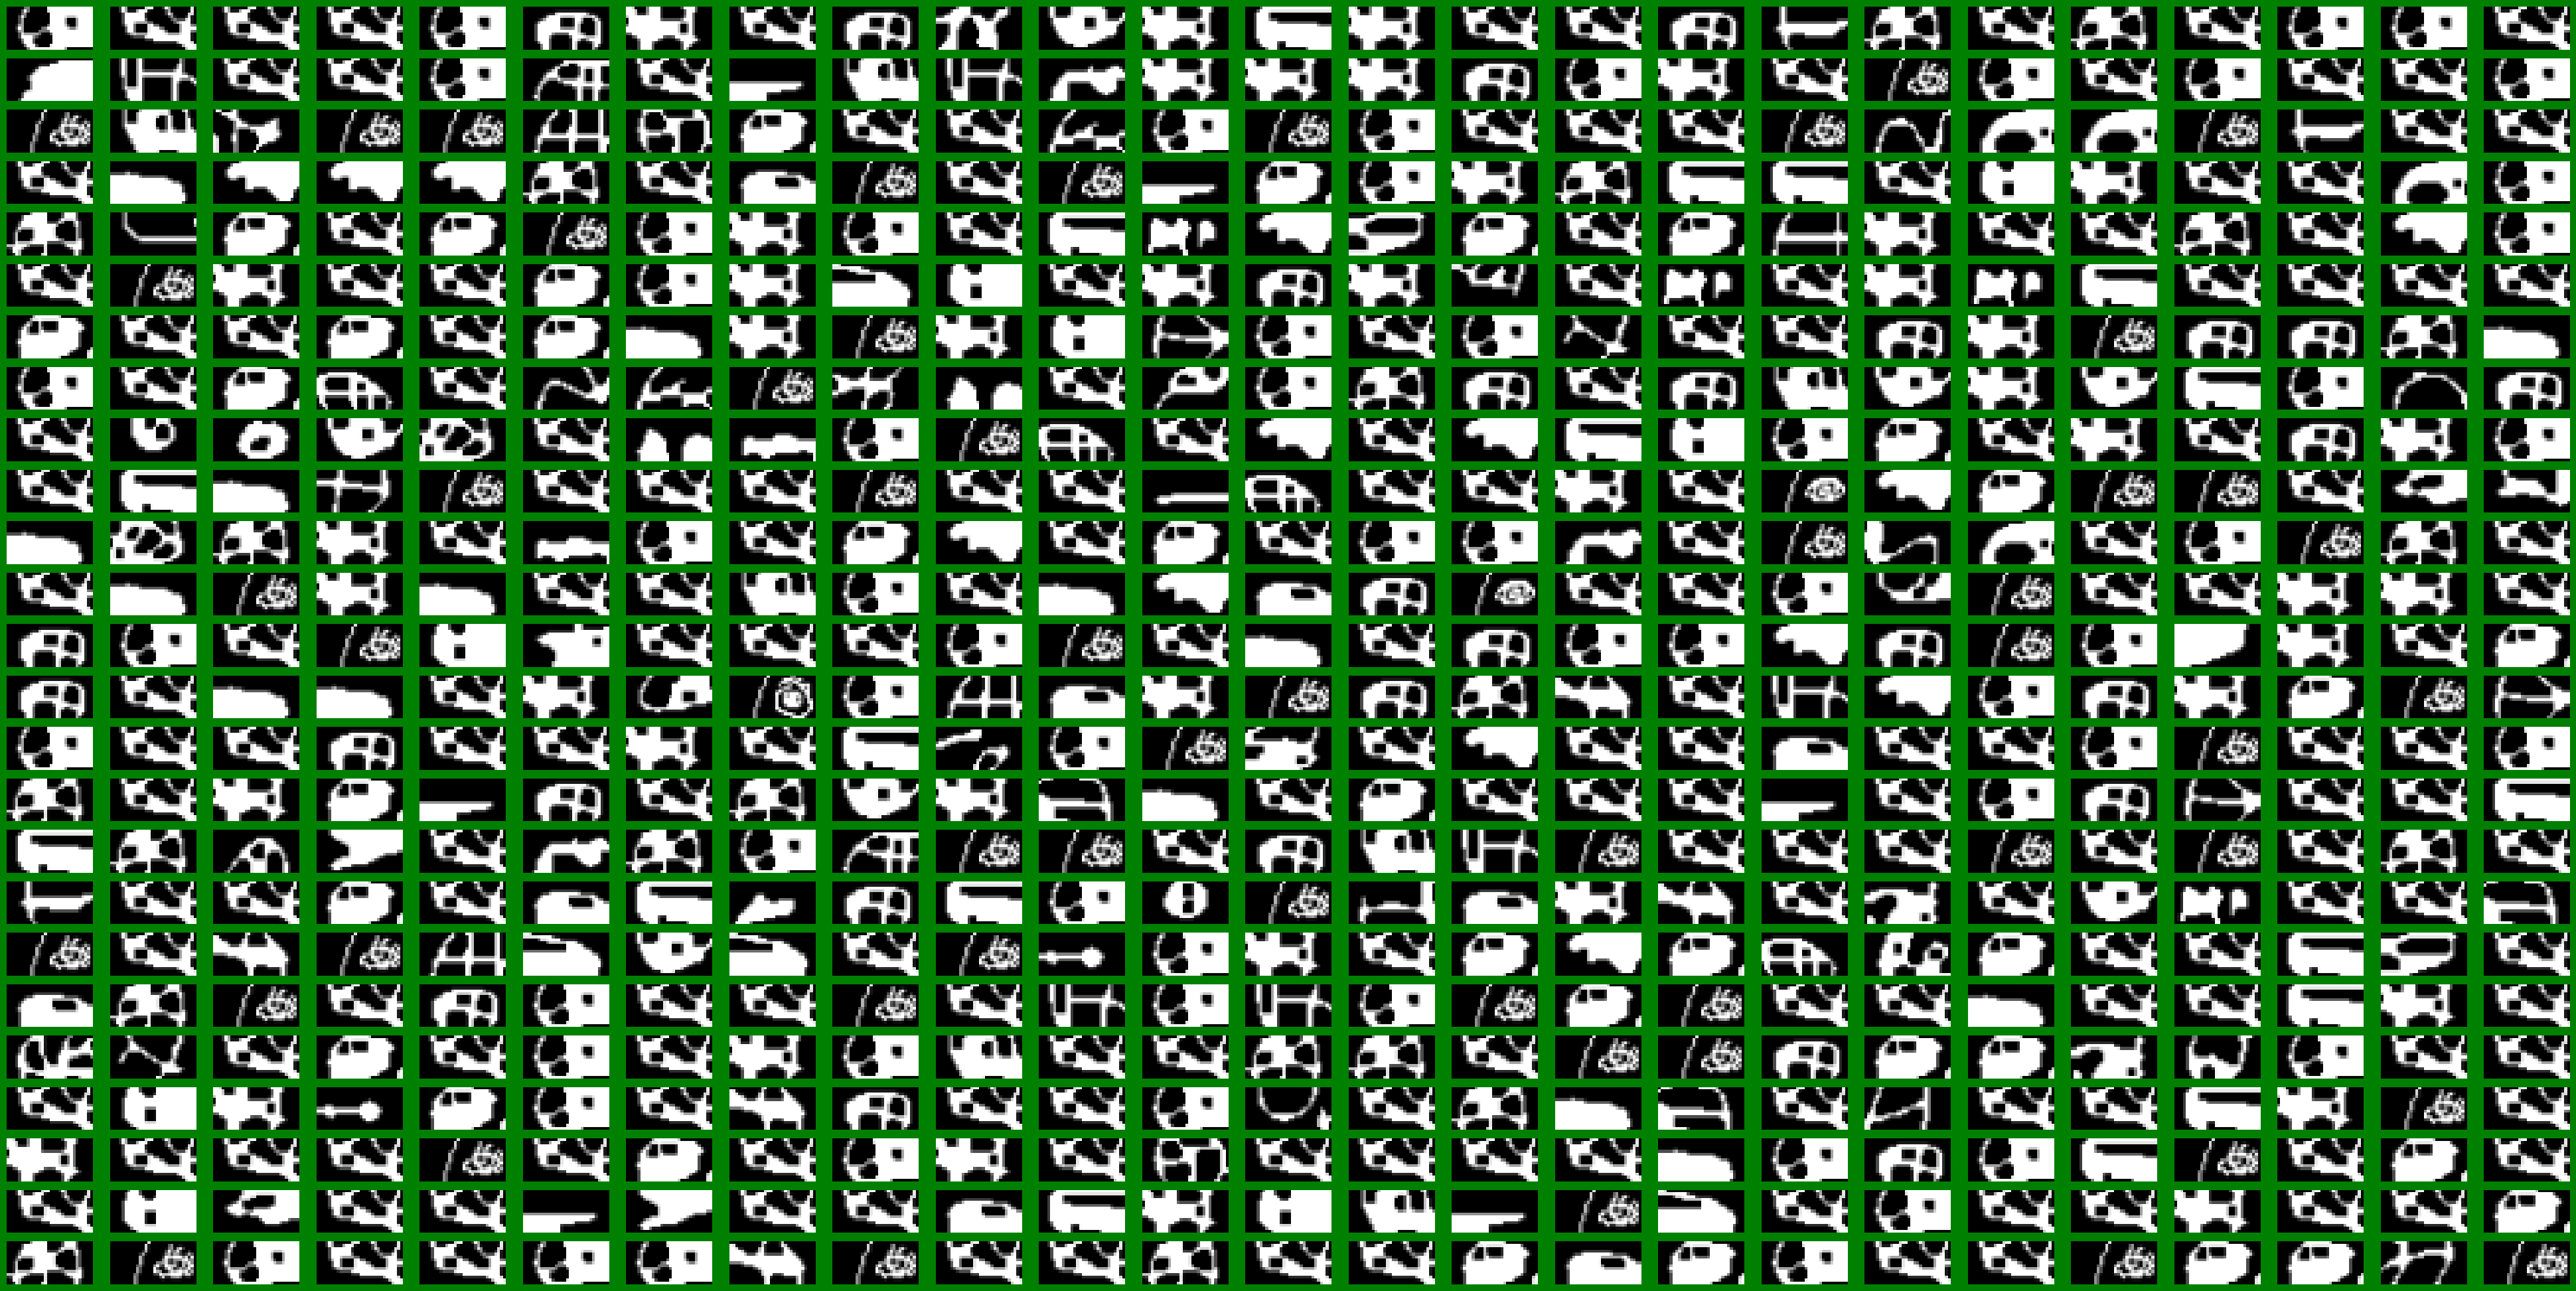

In [193]:
layer = nn.Sequential(*(list(model.convs[0]) + list([model.convs[1][:2]])))
print(layer)

kernel_size=arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0]) 
sfm_filter = torch.prod(torch.tensor(arch['args']['SFM_filters'][:1]), dim=0)
print(kernel_size, stride, sfm_filter)

CI, CI_idx, CI_values = get_ci(images, layer, kernel_size=kernel_size, stride=stride, sfm_filter=sfm_filter)
CIs[1] = CI
CI = CI.reshape((int(CI.shape[0]**0.5), int(CI.shape[0]**0.5), *CI.shape[2:]))
plot_map(CI, cmap='gray')

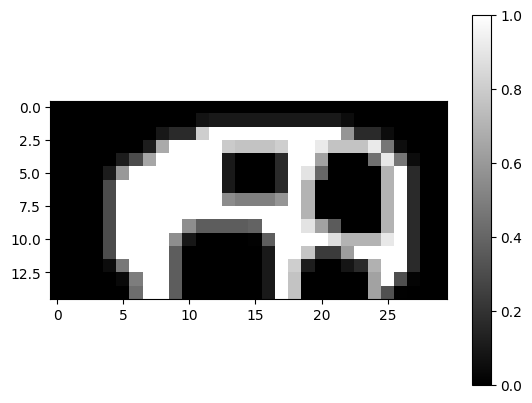

images_idx = 8993, segment_idx = 2
./data/face_dataset/Train\other\baseball_993.png
segments.shape = torch.Size([1, 1, 4, 2, 15, 30])


C:\Users\user\AppData\Local\Temp\ipykernel_32776\3411573377.py:8: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  images_idx = int(CI_idx[i][0] // 8)
C:\Users\user\AppData\Local\Temp\ipykernel_32776\909383208.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


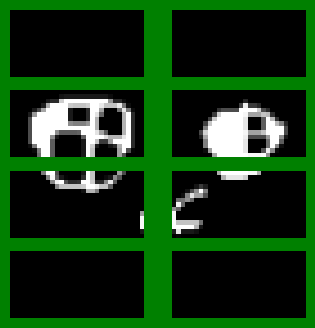

In [198]:
i = 5

# CI, CI_idx, CI_values
plt.imshow(CIs[1][i][0], cmap='gray',vmax=1 ,vmin=0)
plt.colorbar()
plt.show()

images_idx = int(CI_idx[i][0] // 8)
segment_idx = int(CI_idx[i][0] % 8)
print(f"images_idx = {images_idx}, segment_idx = {segment_idx}")

kernel_size= (15, 30)
stride = (15, 30)

print(image_paths[images_idx])
segments = split(images[images_idx].unsqueeze(0), kernel_size=kernel_size, stride=stride)
print(f"segments.shape = {segments.shape}")
plot_map(segments[0].permute(1,2,3,4,0), cmap='gray', vmax=1, vmin=0)

# Layer 2

## FM 2

In [202]:
FMs[2] = model.convs[2][0].weight.reshape(-1, int(model.convs[2][0].weight.shape[1]**0.5), int(model.convs[2][0].weight.shape[1]**0.5), 1)
print(f"FMs[2] = {FMs[2].shape}")

FMs[2] = torch.Size([1225, 25, 25, 1])


Sequential(
  (0): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 1, 15, 15))
    (1): triangle_cReLU(w = 17.85356903076172, percent=0.5)
    (2): SFM(filter=(1, 2), alpha=[[0.9  0.99]])
  )
  (1): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
    (1): triangle_cReLU(w = 15.669326782226562, percent=0.4000000059604645)
    (2): SFM(
      filter=(2, 1), alpha=[[0.9 ]
       [0.99]]
    )
  )
  (2): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (1225, 625, 1, 1))
    (1): triangle_cReLU(w = 25.72799301147461, percent=0.30000001192092896)
  )
)


C:\Users\user\AppData\Local\Temp\ipykernel_10220\1595269499.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


torch.Size([48000, 30, 30, 1])
torch.Size([48000, 1225, 1])
0 tensor(11346) tensor(0.6373)
1 tensor(19182) tensor(0.6631)
2 tensor(11718) tensor(0.6414)
3 tensor(21402) tensor(0.6416)
4 tensor(18590) tensor(0.6511)
5 tensor(0) tensor(0.)
6 tensor(27358) tensor(0.6033)
7 tensor(0) tensor(0.)
8 tensor(0) tensor(0.)
9 tensor(15162) tensor(0.6395)
10 tensor(23822) tensor(0.6900)
11 tensor(6074) tensor(0.6557)
12 tensor(10779) tensor(0.6733)
13 tensor(15162) tensor(0.6396)
14 tensor(20346) tensor(0.6373)
15 tensor(0) tensor(0.)
16 tensor(13070) tensor(0.6604)
17 tensor(6870) tensor(0.6782)
18 tensor(394) tensor(0.6622)
19 tensor(23822) tensor(0.6910)
20 tensor(0) tensor(0.)
21 tensor(23822) tensor(0.7086)
22 tensor(11346) tensor(0.6369)
23 tensor(23822) tensor(0.7175)
24 tensor(27429) tensor(0.5968)
25 tensor(8034) tensor(0.6265)
26 tensor(25184) tensor(0.6290)
27 tensor(23822) tensor(0.7225)
28 tensor(23822) tensor(0.6971)
29 tensor(23822) tensor(0.6936)
30 tensor(11911) tensor(0.6656)
31 

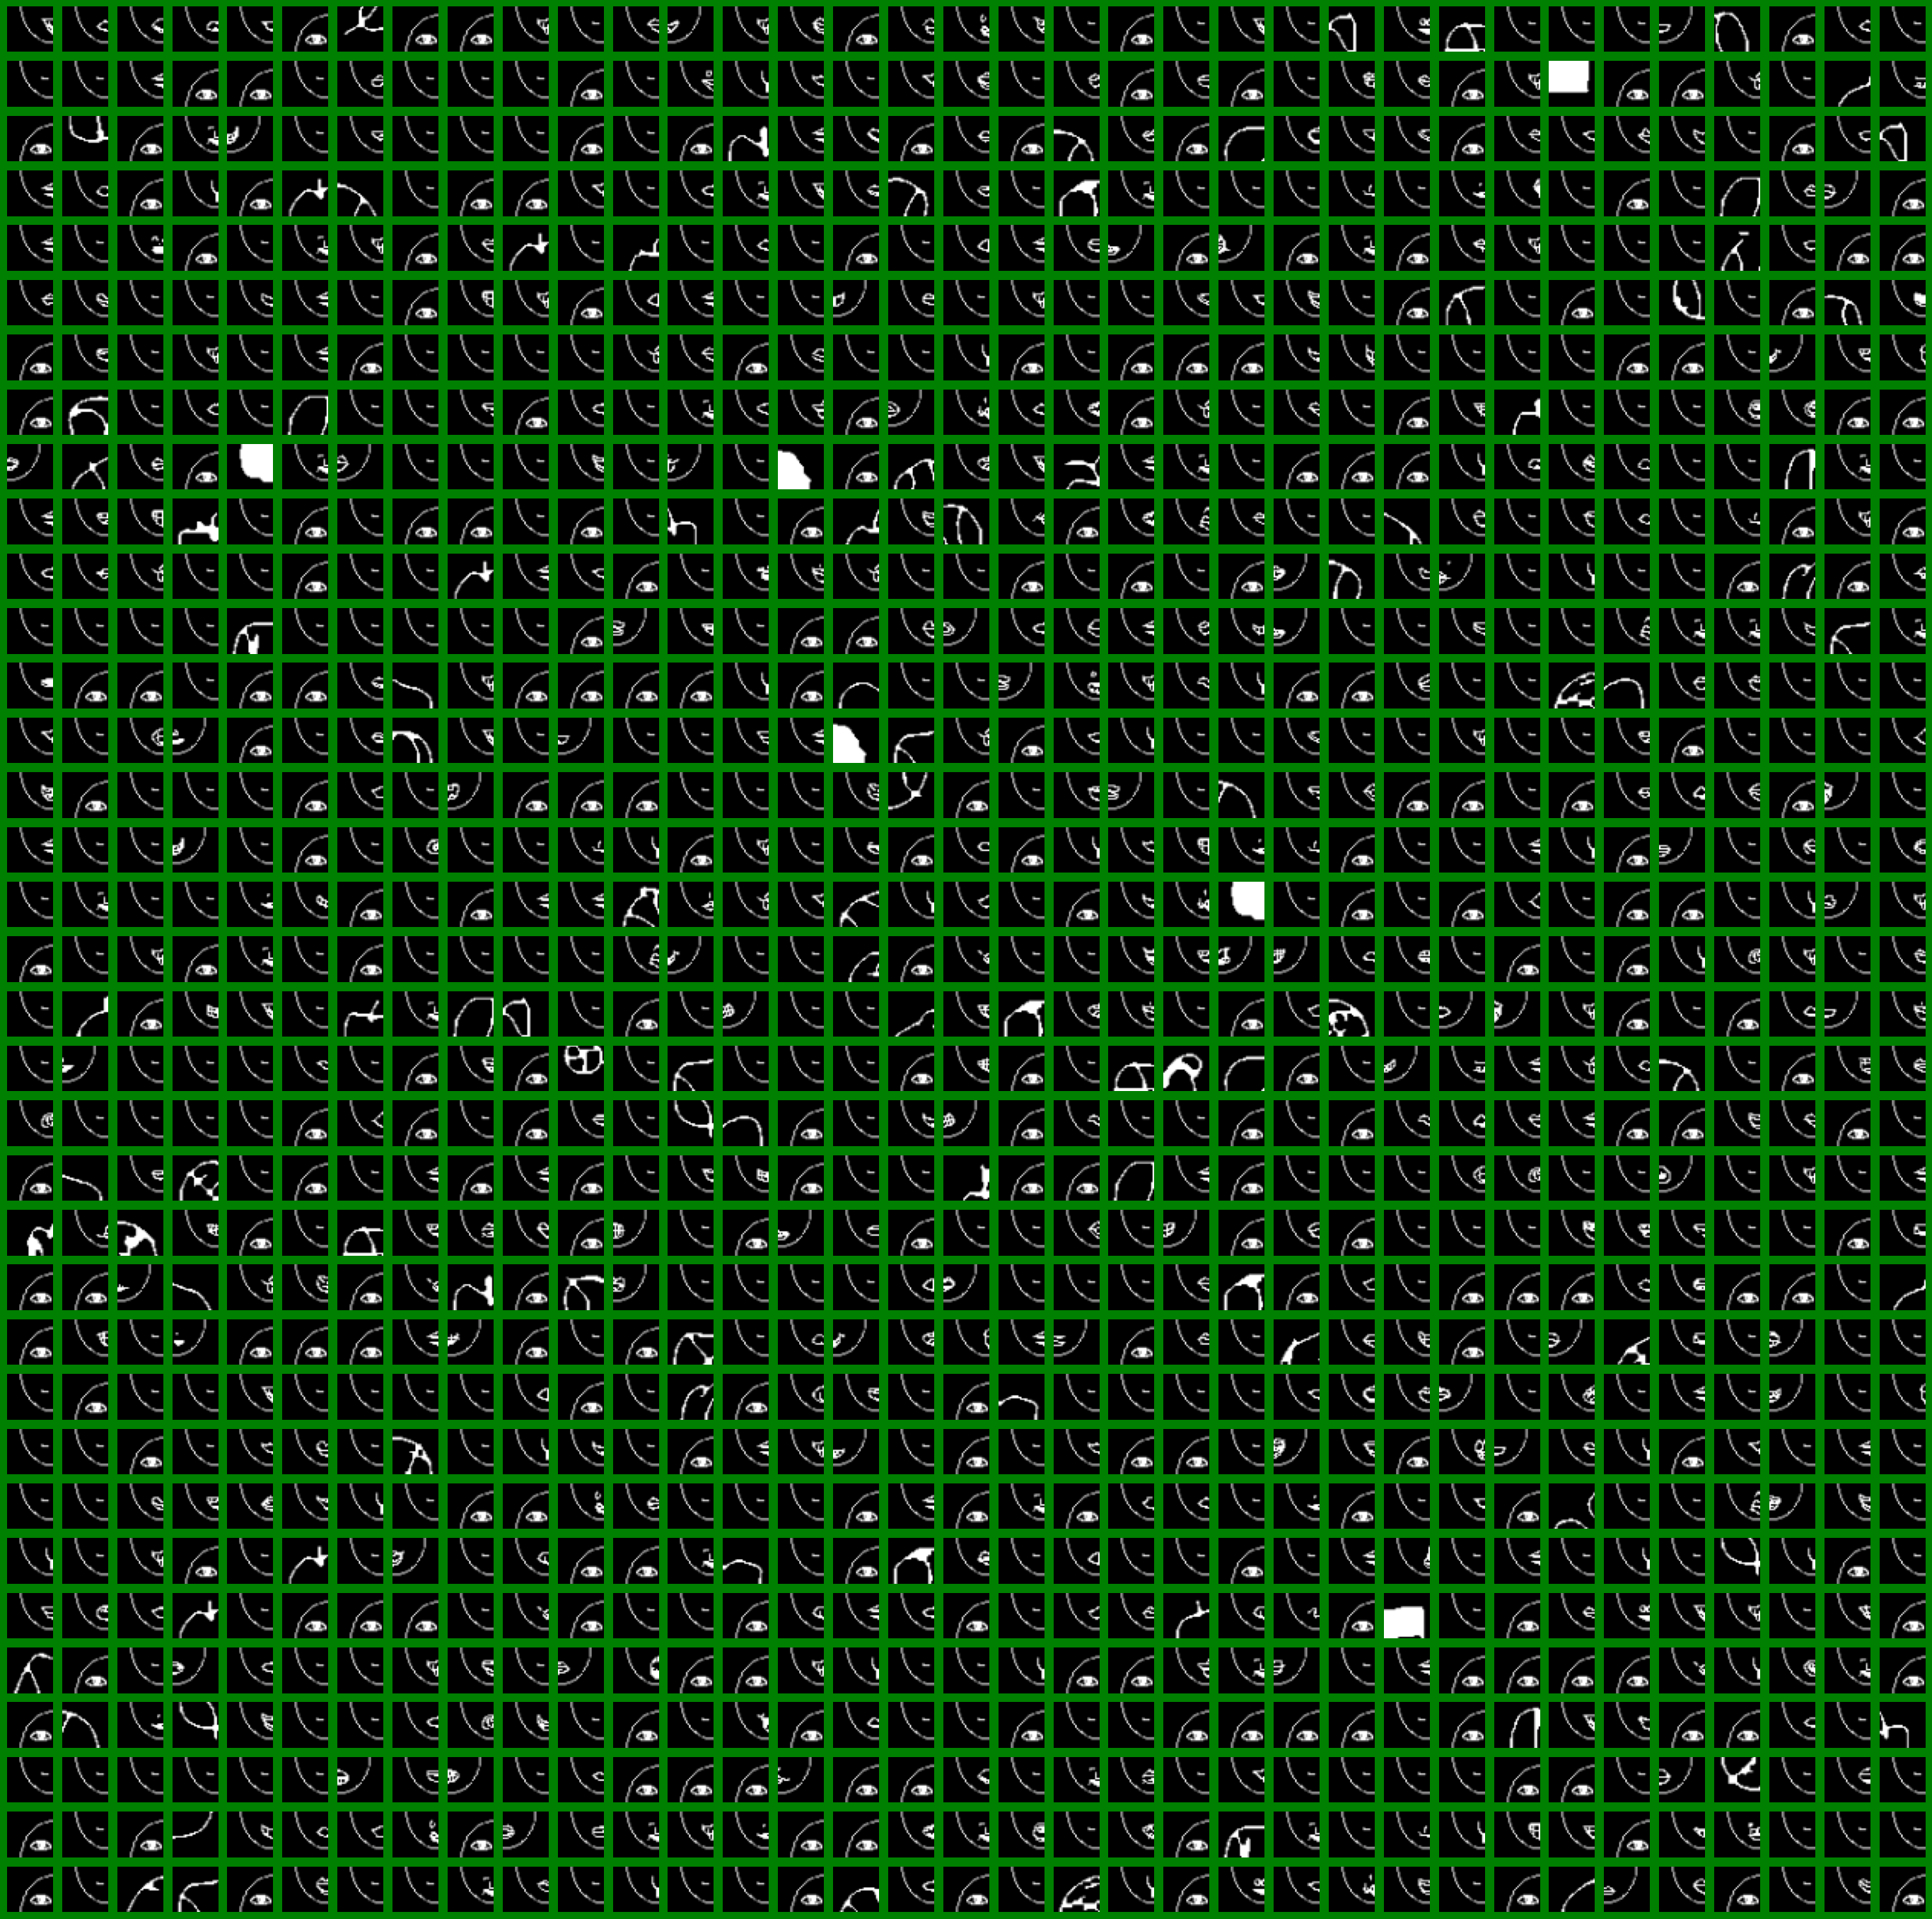

In [ ]:
layer = nn.Sequential(*(list(model.convs[:2]) + list([model.convs[2][:2]])))
print(layer)
CI = get_ci(images, layer, sfm_filter=(2,2))
CI = CI.reshape((int(CI.shape[0]**0.5), int(CI.shape[0]**0.5), *CI.shape[1:]))
plot_map(CI, cmap='gray')
CIs[2] = CI

# CI_3

Sequential(
  (0): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 1, 15, 15))
    (1): triangle_cReLU(w = 17.85356903076172, percent=0.5)
    (2): SFM(filter=(1, 2), alpha=[[0.9  0.99]])
  )
  (1): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
    (1): triangle_cReLU(w = 15.669326782226562, percent=0.4000000059604645)
    (2): SFM(
      filter=(2, 1), alpha=[[0.9 ]
       [0.99]]
    )
  )
  (2): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (1225, 625, 1, 1))
    (1): triangle_cReLU(w = 25.72799301147461, percent=0.30000001192092896)
    (2): SFM(filter=(1, 2), alpha=[[0.9  0.99]])
  )
  (3): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (2025, 1225, 1, 1))
    (1): triangle_cReLU(w = 35.95823669433594, percent=0.20000000298023224)
  )
)


C:\Users\user\AppData\Local\Temp\ipykernel_10220\1595269499.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


torch.Size([24000, 30, 60, 1])
torch.Size([24000, 2025, 1])
0 tensor(0) tensor(0.)
1 tensor(0) tensor(0.)
2 tensor(17921) tensor(0.7500)
3 tensor(0) tensor(0.)
4 tensor(19873) tensor(0.8166)
5 tensor(0) tensor(0.)
6 tensor(0) tensor(0.)
7 tensor(0) tensor(0.)
8 tensor(0) tensor(0.)
9 tensor(0) tensor(0.)
10 tensor(0) tensor(0.)
11 tensor(0) tensor(0.)
12 tensor(0) tensor(0.)
13 tensor(0) tensor(0.)
14 tensor(19873) tensor(0.8224)
15 tensor(0) tensor(0.)
16 tensor(19873) tensor(0.8234)
17 tensor(0) tensor(0.)
18 tensor(0) tensor(0.)
19 tensor(19873) tensor(0.8156)
20 tensor(0) tensor(0.)
21 tensor(0) tensor(0.)
22 tensor(0) tensor(0.)
23 tensor(0) tensor(0.)
24 tensor(0) tensor(0.)
25 tensor(0) tensor(0.)
26 tensor(0) tensor(0.)
27 tensor(0) tensor(0.)
28 tensor(0) tensor(0.)
29 tensor(0) tensor(0.)
30 tensor(0) tensor(0.)
31 tensor(0) tensor(0.)
32 tensor(0) tensor(0.)
33 tensor(19873) tensor(0.8251)
34 tensor(19873) tensor(0.8204)
35 tensor(12396) tensor(0.7858)
36 tensor(0) tensor(0.

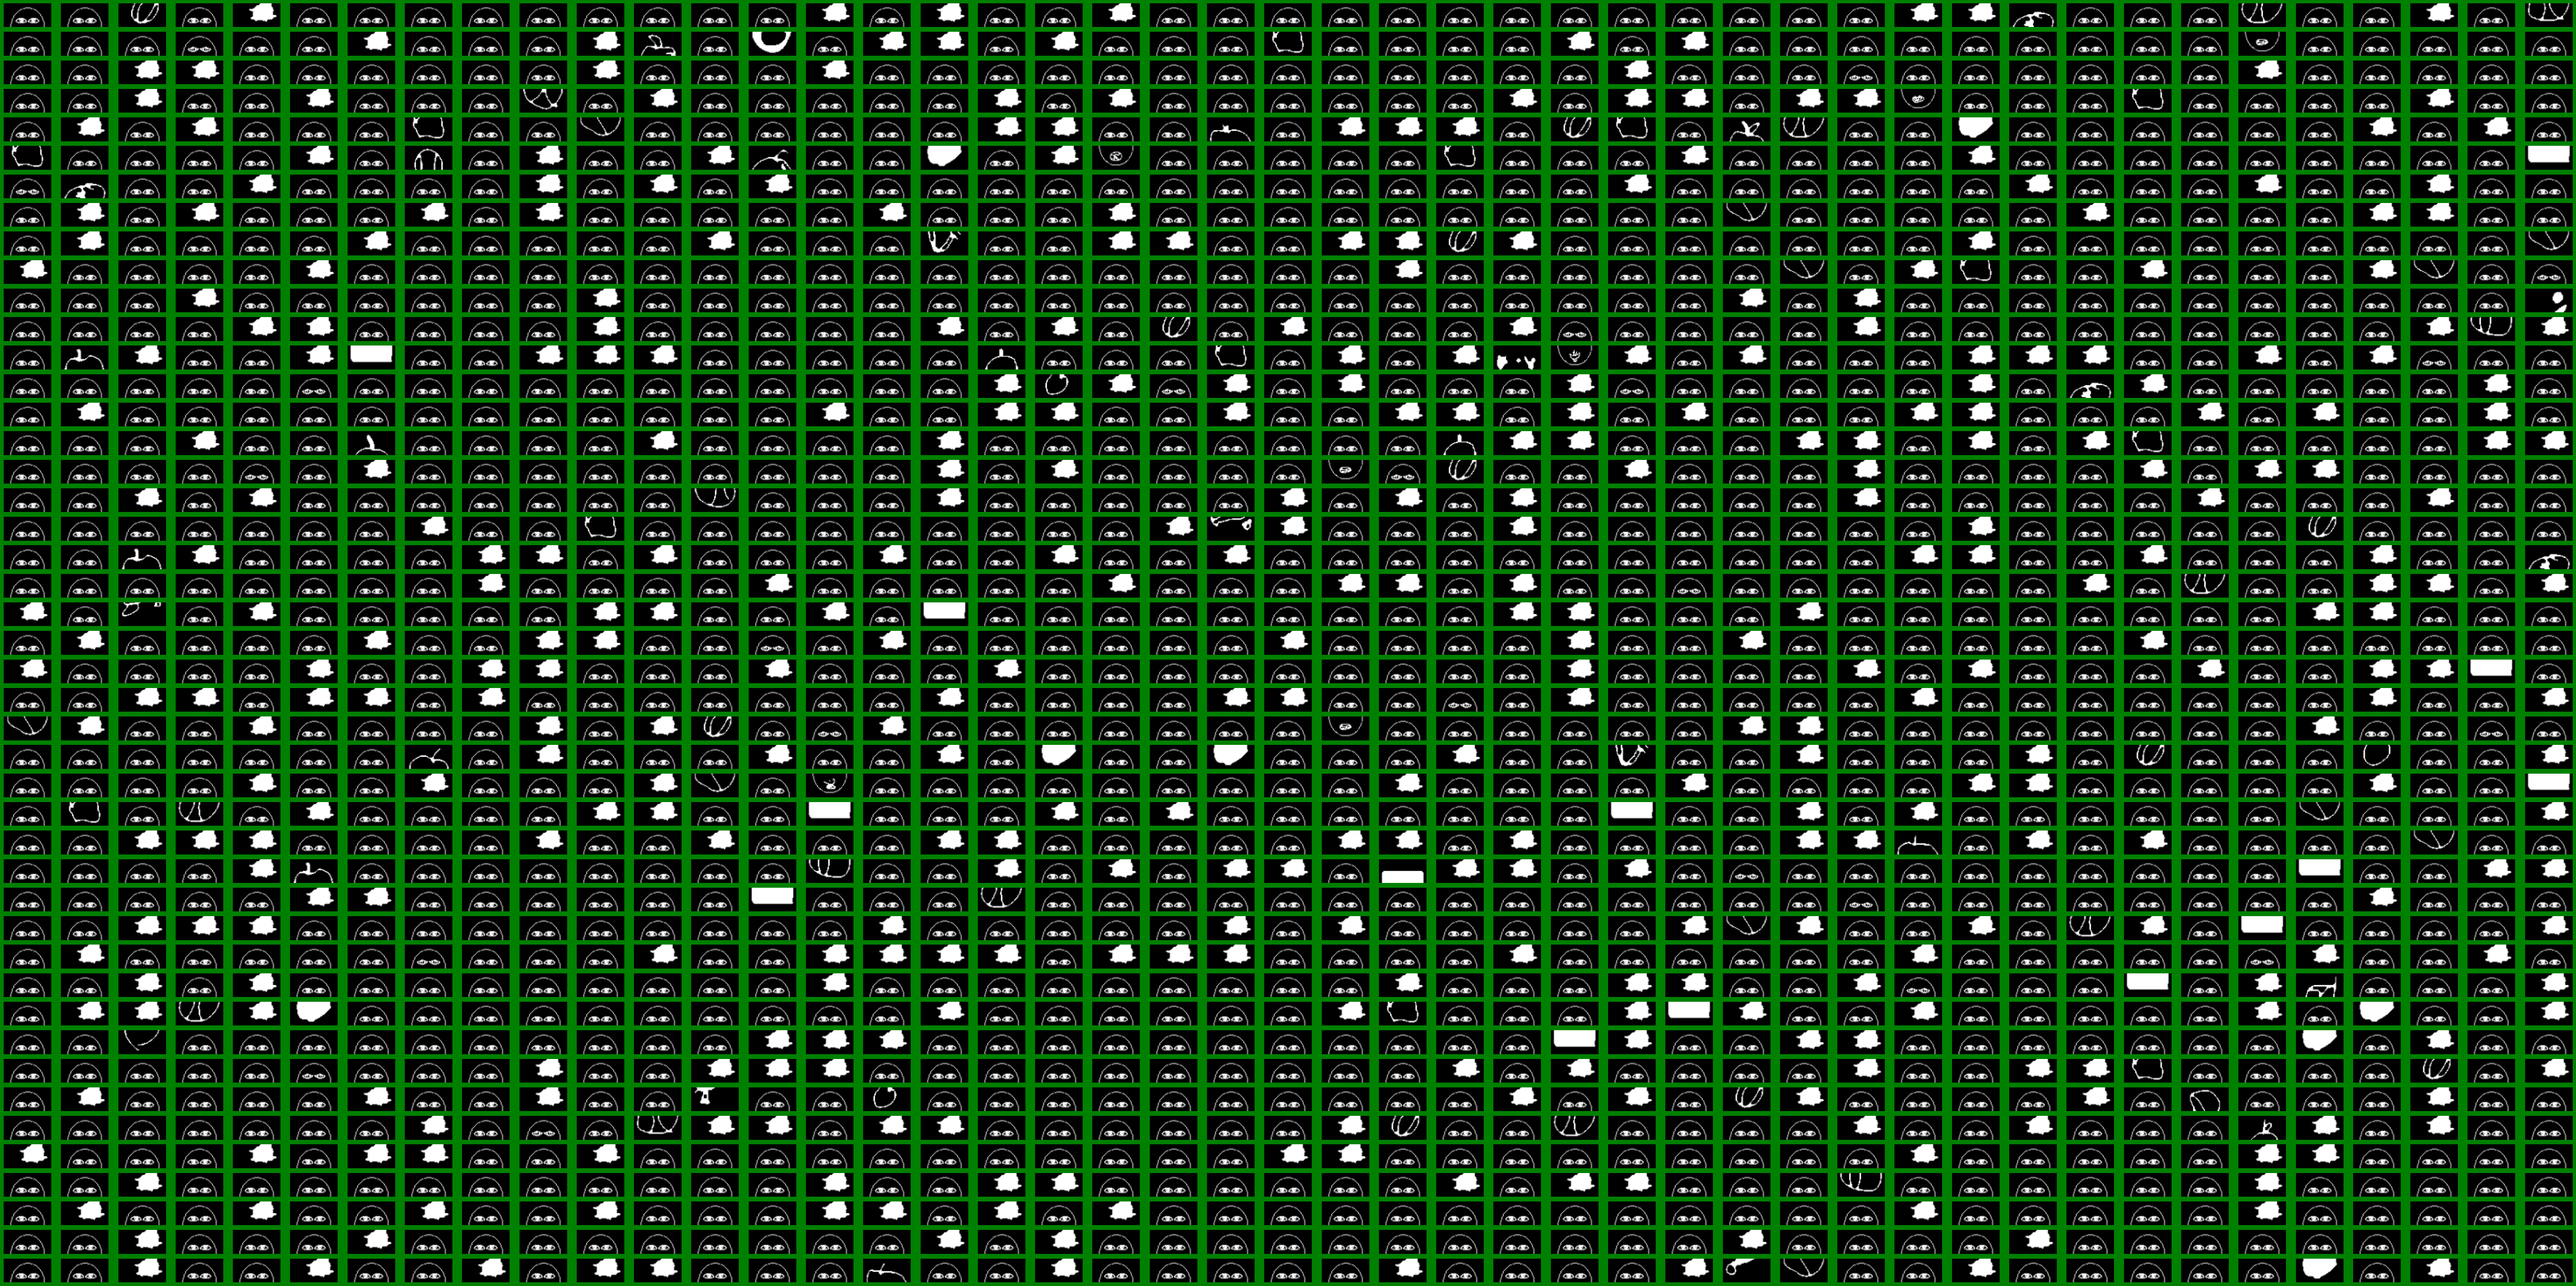

In [ ]:
layer = nn.Sequential(*(list(model.convs[:3]) + list([model.convs[3][:2]])))
print(layer)
CI = get_ci(images, layer, sfm_filter=(2,4))
CI = CI.reshape((int(CI.shape[0]**0.5), int(CI.shape[0]**0.5), *CI.shape[1:]))
plot_map(CI, cmap='gray')
CIs[3] = CI